# Exploratory Data Analysis (EDA) — NYC Yellow Taxi 2024

## Introduction

In this section, we will perform an exploratory data analysis (EDA) on the full 12-month NYC Yellow Taxi Trip dataset, now fully loaded into MySQL (~41M records). The goal is to extract key insights and trends from the data, including:

- Total trips per month
- Average fare and tip analysis
- Payment type trends

## Why we are creating indexes

Since the dataset is large (~41 million rows), performing aggregation queries directly on the raw table can be very slow. To optimize query performance for our EDA, we will create indexes on the columns that are most frequently used in `GROUP BY`, `WHERE`, and `ORDER BY` clauses:

- `pu_location_id` → used for geospatial and pickup analysis
- `do_location_id` → used for dropoff analysis
- `tpep_pickup_datetime` → used to group trips by month and time

Creating these indexes will significantly improve the speed of our queries and make the analysis more efficient and interactive.

**Note:** The index creation step is safe to run multiple times — if an index already exists, MySQL will report it and skip re-creating it.


In [1]:
import mysql.connector
from dotenv import load_dotenv
import os

# Load env variables
load_dotenv()

# MySQL connection config
MYSQL_CONFIG = {
    'user': os.getenv('MYSQL_USER'),
    'password': os.getenv('MYSQL_PASSWORD'),
    'host': os.getenv('MYSQL_HOST'),
    'database': os.getenv('MYSQL_DATABASE'),
    'port': int(os.getenv('MYSQL_PORT'))
}

## Index Management

To optimize query performance on the `yellow_taxi_trips` table (~41M rows), we use dedicated indexes on key columns:

- `pu_location_id` → for pickup zone analysis
- `do_location_id` → for dropoff zone analysis
- `tpep_pickup_datetime` → for time-based aggregations (e.g. trips per month)

### Why use flags to control index operations?

- Creating or dropping indexes on large tables can take several minutes.
- Even attempting to create an index that already exists forces MySQL to check the table and can cause temporary performance impact.
- For this reason, index operations are controlled explicitly by `DROP_INDEXES` and `CREATE_INDEXES` flags in the notebook.

**Usage:**

- Set `DROP_INDEXES = True` to drop existing indexes if needed.
- Set `CREATE_INDEXES = True` to create the required indexes (usually run once during setup).
- Default is to skip both operations to ensure fast and safe re-runs of the notebook.

### Notes:

- Dropping and recreating indexes is safe: it does not affect the underlying table data.
- It is good practice to document and control index management in reproducible analytical pipelines.


In [ ]:
# Index Management Block
# ⚙️ Use DROP_INDEXES and CREATE_INDEXES flags to control index operations.
# ⚠️ On large tables (~41M rows), index operations can take several minutes.

DROP_INDEXES = False  # Set to True to drop existing indexes (if needed)
CREATE_INDEXES = False  # Set to True to create indexes (recommended to run only once)

# Indexes to manage
index_names = [
    "idx_pu_location_id",
    "idx_do_location_id",
    "idx_tpep_pickup_datetime"
]

index_statements = [
    ("idx_pu_location_id", "CREATE INDEX idx_pu_location_id ON yellow_taxi_trips(pu_location_id);"),
    ("idx_do_location_id", "CREATE INDEX idx_do_location_id ON yellow_taxi_trips(do_location_id);"),
    ("idx_tpep_pickup_datetime", "CREATE INDEX idx_tpep_pickup_datetime ON yellow_taxi_trips(tpep_pickup_datetime);")
]

# Connect to MySQL
cnx = mysql.connector.connect(**MYSQL_CONFIG)
cursor = cnx.cursor()

# Drop indexes if requested
if DROP_INDEXES:
    print("⚠️ Dropping indexes...")
    for index_name in index_names:
        try:
            print(f"Dropping index {index_name}...")
            cursor.execute(f"DROP INDEX {index_name} ON yellow_taxi_trips;")
            cnx.commit()
            print(f"✅ Index {index_name} dropped.")
        except mysql.connector.Error as err:
            print(f"⚠️ Could not drop index {index_name}: {err.msg}")
    print("🏁 Index drop process complete.")
else:
    print("⏭️ Skipping index drop.")

# Create indexes if requested
if CREATE_INDEXES:
    print("⚙️ Creating indexes...")
    for index_name, stmt in index_statements:
        try:
            print(f"Creating index {index_name}...")
            cursor.execute(stmt)
            cnx.commit()
            print(f"✅ Index {index_name} created.")
        except mysql.connector.Error as err:
            print(f"⚠️ Could not create index {index_name}: {err.msg}")
    print("🏁 Index creation process complete.")
else:
    print("⏭️ Skipping index creation.")

# Close connection
cursor.close()
cnx.close()


⏭️ Skipping index drop.
⏭️ Skipping index creation.


`On the initial run:`
```text
⚠️ Dropping indexes...
Dropping index idx_pu_location_id...
✅ Index idx_pu_location_id dropped.
Dropping index idx_do_location_id...
✅ Index idx_do_location_id dropped.
Dropping index idx_tpep_pickup_datetime...
⚠️ Could not drop index idx_tpep_pickup_datetime: Can't DROP 'idx_tpep_pickup_datetime'; check that column/key exists
🏁 Index drop process complete.
⚙️ Creating indexes...
Creating index idx_pu_location_id...
✅ Index idx_pu_location_id created.
Creating index idx_do_location_id...
✅ Index idx_do_location_id created.
Creating index idx_tpep_pickup_datetime...
✅ Index idx_tpep_pickup_datetime created.
🏁 Index creation process complete.
```

## Total Trips per Month

We analyze the evolution of total trips over time (monthly) to detect seasonality and trends in NYC taxi usage.


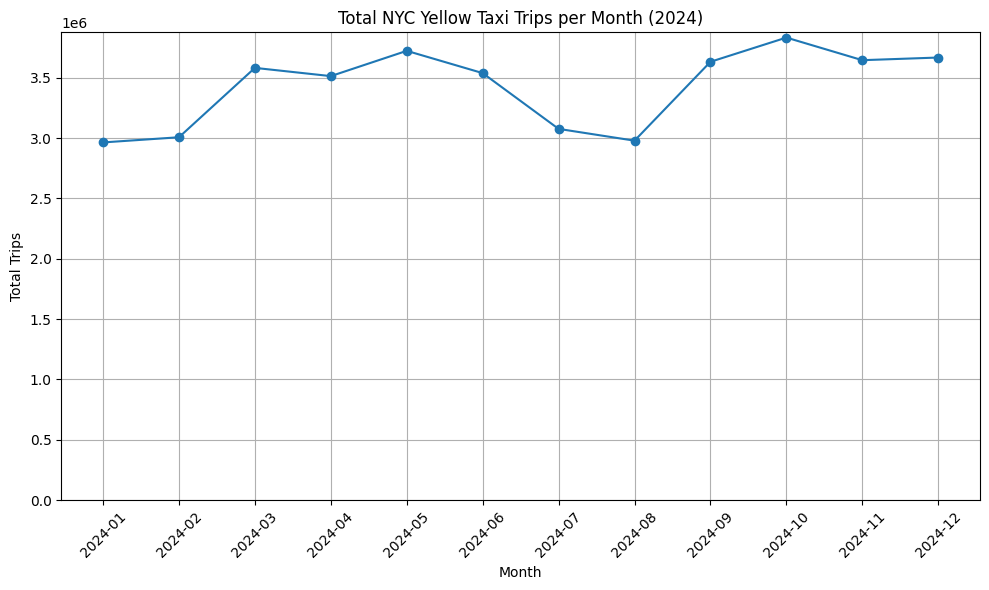

In [7]:
# Total Trips per Month

import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector

# Ensure eda_results folder exists
os.makedirs('../eda_results', exist_ok=True)

# Connect to MySQL
cnx = mysql.connector.connect(**MYSQL_CONFIG)
cursor = cnx.cursor()

# SQL query: total trips per month
query = """
SELECT
    DATE_FORMAT(tpep_pickup_datetime, '%Y-%m') AS month,
    COUNT(*) AS total_trips
FROM yellow_taxi_trips
GROUP BY month
ORDER BY month;
"""

# Execute query
cursor.execute(query)
results = cursor.fetchall()

# Close connection
cursor.close()
cnx.close()

# Load results into DataFrame
df_trips_per_month = pd.DataFrame(results, columns=['month', 'total_trips'])

# Filter only valid 2024 dates (strict sanity check)
df_trips_valid = df_trips_per_month[df_trips_per_month['month'].between('2024-01', '2024-12')]

# Plot only valid months
plt.figure(figsize=(10,6))
plt.plot(df_trips_valid['month'], df_trips_valid['total_trips'], marker='o')
plt.title('Total NYC Yellow Taxi Trips per Month (2024)')
plt.xlabel('Month')
plt.ylabel('Total Trips')
plt.xticks(rotation=45)
plt.ylim(bottom=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Save clean version to CSV
df_trips_valid.to_csv('../eda_results/total_trips_per_month_2024_clean.csv', index=False)


## Data Quality Assessment

During the initial exploratory analysis, we observed some data quality issues — specifically, trips with pickup dates outside of the expected 2024 range.

This is a common situation when working with large real-world datasets, such as the NYC Yellow Taxi Trip Data. Data inconsistencies may arise from:

- Incorrect timestamps (e.g. due to device clock errors)
- Missing or null values
- Unexpected values in categorical columns (e.g. invalid payment type codes)
- Outliers in numerical fields (e.g. negative trip distances or fares)

Before proceeding with further analysis, we will perform a basic data quality assessment to better understand the overall condition of our dataset. This step ensures that we can make informed decisions about cleaning and filtering the data for reliable insights.


In [9]:
# Data Quality Checks

import pandas as pd
import mysql.connector
import os

# Ensure eda_results folder exists
os.makedirs('../eda_results', exist_ok=True)

# Connect to MySQL
cnx = mysql.connector.connect(**MYSQL_CONFIG)
cursor = cnx.cursor()

# 1️⃣ Pickup datetime: min and max
query_dates = """
SELECT
    MIN(tpep_pickup_datetime) AS min_pickup_datetime,
    MAX(tpep_pickup_datetime) AS max_pickup_datetime
FROM yellow_taxi_trips;
"""
cursor.execute(query_dates)
dates_result = cursor.fetchall()
df_dates = pd.DataFrame(dates_result, columns=['min_pickup_datetime', 'max_pickup_datetime'])
df_dates.to_csv('../eda_results/data_quality_pickup_datetime_range.csv', index=False)

# 2️⃣ Null value counts
query_nulls = """
SELECT
    SUM(tpep_pickup_datetime IS NULL) AS pickup_nulls,
    SUM(tpep_dropoff_datetime IS NULL) AS dropoff_nulls,
    SUM(passenger_count IS NULL) AS passenger_count_nulls,
    SUM(trip_distance IS NULL) AS trip_distance_nulls,
    SUM(fare_amount IS NULL) AS fare_amount_nulls,
    SUM(payment_type IS NULL) AS payment_type_nulls
FROM yellow_taxi_trips;
"""
cursor.execute(query_nulls)
nulls_result = cursor.fetchall()
df_nulls = pd.DataFrame(nulls_result, columns=[
    'pickup_nulls', 'dropoff_nulls', 'passenger_count_nulls',
    'trip_distance_nulls', 'fare_amount_nulls', 'payment_type_nulls'
])
df_nulls.to_csv('../eda_results/data_quality_null_counts.csv', index=False)

# 3️⃣ Negative trip distance and fare amounts
query_negatives = """
SELECT
    SUM(trip_distance < 0) AS negative_trip_distance,
    SUM(fare_amount < 0) AS negative_fare_amount
FROM yellow_taxi_trips;
"""
cursor.execute(query_negatives)
negatives_result = cursor.fetchall()
df_negatives = pd.DataFrame(negatives_result, columns=['negative_trip_distance', 'negative_fare_amount'])
df_negatives.to_csv('../eda_results/data_quality_negative_values.csv', index=False)

# 4️⃣ Unexpected payment_type values
# Valid values: 1=Credit card, 2=Cash, 3=No charge, 4=Dispute, 5=Unknown, 6=Voided trip
query_payment_types = """
SELECT
    payment_type,
    COUNT(*) AS count
FROM yellow_taxi_trips
GROUP BY payment_type
ORDER BY payment_type;
"""
cursor.execute(query_payment_types)
payment_types_result = cursor.fetchall()
df_payment_types = pd.DataFrame(payment_types_result, columns=['payment_type', 'count'])
df_payment_types.to_csv('../eda_results/data_quality_payment_type_distribution.csv', index=False)

# Close connection
cursor.close()
cnx.close()

# Summary printout
print("✅ Data Quality Checks completed.")
print("✅ Results saved to '../eda_results/' folder:")
print("- data_quality_pickup_datetime_range.csv")
print("- data_quality_null_counts.csv")
print("- data_quality_negative_values.csv")
print("- data_quality_payment_type_distribution.csv")


✅ Data Quality Checks completed.
✅ Results saved to '../eda_results/' folder:
- data_quality_pickup_datetime_range.csv
- data_quality_null_counts.csv
- data_quality_negative_values.csv
- data_quality_payment_type_distribution.csv


## Average Fare and Tip per Month

We analyze the evolution of average fare amount and average tip amount over time (monthly).

### Data cleaning applied:

- Only trips with pickup dates in 2024 (`2024-01-01` to `2024-12-31`)
- Only trips with `trip_distance >= 0` and `fare_amount >= 0` to avoid obvious data errors


✅ Results saved to '../eda_results/avg_fare_and_tip_per_month_2024_clean.csv'


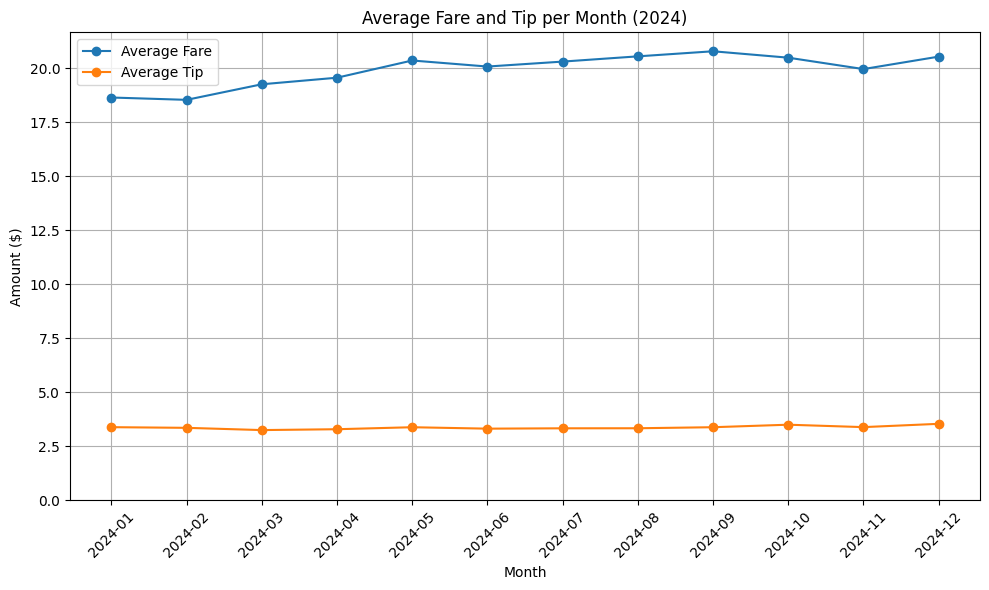

In [11]:
# Average Fare and Tip per Month

import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector
import os

# Ensure eda_results folder exists
os.makedirs('../eda_results', exist_ok=True)

# Connect to MySQL
cnx = mysql.connector.connect(**MYSQL_CONFIG)
cursor = cnx.cursor()

# SQL query: average fare and tip per month, with basic cleaning
query_fare_tip = """
SELECT
    DATE_FORMAT(tpep_pickup_datetime, '%Y-%m') AS month,
    AVG(fare_amount) AS avg_fare,
    AVG(tip_amount) AS avg_tip
FROM yellow_taxi_trips
WHERE
    tpep_pickup_datetime >= '2024-01-01' AND tpep_pickup_datetime < '2025-01-01'
    AND trip_distance >= 0
    AND fare_amount >= 0
GROUP BY month
ORDER BY month;
"""

# Execute query
cursor.execute(query_fare_tip)
results_fare_tip = cursor.fetchall()

# Close connection
cursor.close()
cnx.close()

# Load results into DataFrame
df_fare_tip = pd.DataFrame(results_fare_tip, columns=['month', 'avg_fare', 'avg_tip'])

# Save results to CSV for future use (dashboards etc.)
df_fare_tip.to_csv('../eda_results/avg_fare_and_tip_per_month_2024_clean.csv', index=False)
print("✅ Results saved to '../eda_results/avg_fare_and_tip_per_month_2024_clean.csv'")

# Plot
plt.figure(figsize=(10,6))
plt.plot(df_fare_tip['month'], df_fare_tip['avg_fare'], marker='o', label='Average Fare')
plt.plot(df_fare_tip['month'], df_fare_tip['avg_tip'], marker='o', label='Average Tip')
plt.title('Average Fare and Tip per Month (2024)')
plt.xlabel('Month')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)
plt.ylim(bottom=0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Payment Type Trends

We analyze the distribution of payment types used by NYC Yellow Taxi customers during 2024.

### Data cleaning applied:

- Only trips with pickup dates in 2024 (`2024-01-01` to `2024-12-31`)
- Only trips with `payment_type` between 1 and 6 (valid documented values)


✅ Results saved to '../eda_results/payment_type_trends_2024_clean.csv'


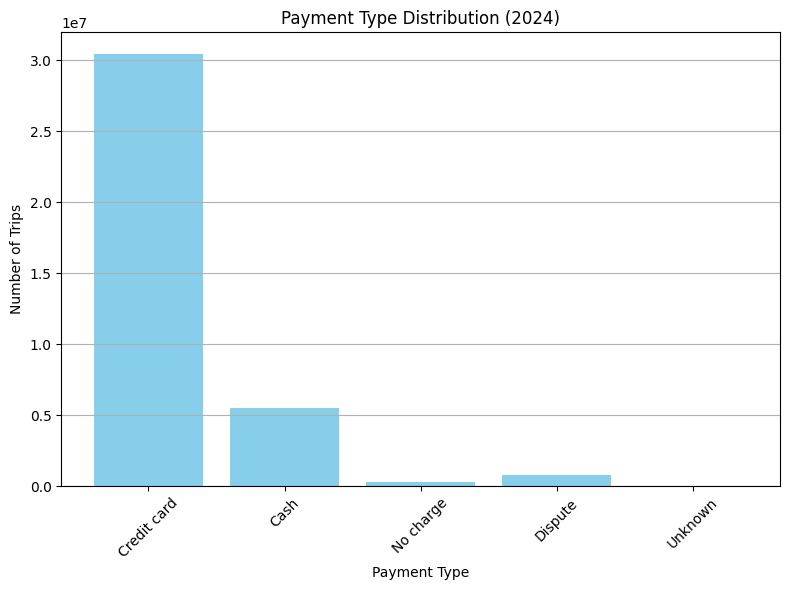

In [12]:
# Payment Type Trends

import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector
import os

# Ensure eda_results folder exists
os.makedirs('../eda_results', exist_ok=True)

# Connect to MySQL
cnx = mysql.connector.connect(**MYSQL_CONFIG)
cursor = cnx.cursor()

# SQL query: payment type distribution, cleaned
query_payment_type = """
SELECT
    payment_type,
    COUNT(*) AS total_trips
FROM yellow_taxi_trips
WHERE
    tpep_pickup_datetime >= '2024-01-01' AND tpep_pickup_datetime < '2025-01-01'
    AND payment_type BETWEEN 1 AND 6
GROUP BY payment_type
ORDER BY payment_type;
"""

# Execute query
cursor.execute(query_payment_type)
results_payment_type = cursor.fetchall()

# Close connection
cursor.close()
cnx.close()

# Load results into DataFrame
df_payment_type = pd.DataFrame(results_payment_type, columns=['payment_type', 'total_trips'])

# Map payment_type codes to labels
payment_type_labels = {
    1: 'Credit card',
    2: 'Cash',
    3: 'No charge',
    4: 'Dispute',
    5: 'Unknown',
    6: 'Voided trip'
}

df_payment_type['payment_type_label'] = df_payment_type['payment_type'].map(payment_type_labels)

# Save results to CSV
df_payment_type.to_csv('../eda_results/payment_type_trends_2024_clean.csv', index=False)
print("✅ Results saved to '../eda_results/payment_type_trends_2024_clean.csv'")

# Plot
plt.figure(figsize=(8,6))
plt.bar(df_payment_type['payment_type_label'], df_payment_type['total_trips'], color='skyblue')
plt.title('Payment Type Distribution (2024)')
plt.xlabel('Payment Type')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## 📊 Exporting EDA Views to CSV

In this section, we extract a set of **predefined SQL views** from our `nyc_taxi_db` database.

The views are defined in [`eda_views/views.sql`](../eda_views/views.sql) and provide useful aggregations for our EDA and Tableau dashboards:

1️⃣ `rides_per_day` → Rides per day (volume and revenue)  
2️⃣ `rides_per_hour_of_day` → Rides per hour of day  
3️⃣ `pickups_per_location` → Total pickups per pickup location  
4️⃣ `fare_vs_distance` → Relationship between fare and trip distance  
5️⃣ `rides_by_passenger_count` → Rides and avg fare by passenger count  
6️⃣ `revenue_pickup_dropoff_matrix` → Revenue matrix by pickup → dropoff  
7️⃣ `distance_by_hour` → Avg / min / max distance by pickup hour  

### Workflow:

- We connect to MySQL using the credentials defined in our `.env` file.
- For each view, we perform a `SELECT * FROM <view>` query.
- We save each result as a `.csv` file in the folder:  
  `../eda_results/exported_views/`
- If the `.csv` file for a given view already exists, we skip that extraction (idempotent logic).

👉 These exported CSVs are used both in Python EDA and in Tableau dashboards.



In [2]:
# Import packages
import os
import pandas as pd
import sqlalchemy
from dotenv import load_dotenv
# from tqdm import tqdm  # Uncomment if you want a progress bar

# Load environment variables
load_dotenv()

MYSQL_USER = os.getenv("MYSQL_USER")
MYSQL_PASSWORD = os.getenv("MYSQL_PASSWORD")
MYSQL_HOST = os.getenv("MYSQL_HOST")
MYSQL_PORT = os.getenv("MYSQL_PORT")
MYSQL_DATABASE = os.getenv("MYSQL_DATABASE")

# Build SQLAlchemy connection string
connection_string = f"mysql+mysqlconnector://{MYSQL_USER}:{MYSQL_PASSWORD}@{MYSQL_HOST}:{MYSQL_PORT}/{MYSQL_DATABASE}"

# Connect to MySQL
engine = sqlalchemy.create_engine(connection_string)

# Output directory
output_dir = "../eda_results/exported_views"
os.makedirs(output_dir, exist_ok=True)

print(f"Saving views to: {os.path.abspath(output_dir)}")

# List of views to extract
views = [
    "rides_per_day",
    "rides_per_hour_of_day",
    "pickups_per_location",
    "fare_vs_distance",
    "rides_by_passenger_count",
    "revenue_pickup_dropoff_matrix",
    "distance_by_hour"
]

# Extraction loop
# for view in tqdm(views):  # Uncomment if you want tqdm progress bar
for view in views:
    output_path = os.path.join(output_dir, f"{view}.csv")
    
    if os.path.exists(output_path):
        print(f"Skipping view {view} — file already exists at {output_path}")
        continue  # Skip this view
    
    try:
        print(f"Extracting view: {view}")
        
        # Special case: fare_vs_distance → limit number of rows
        if view == "fare_vs_distance":
            query = f"SELECT * FROM {view} LIMIT 100000;"
        else:
            query = f"SELECT * FROM {view};"
        
        df = pd.read_sql(query, con=engine)
        
        df.to_csv(output_path, index=False)
        
        print(f"Saved to: {output_path} — {len(df)} rows")
    
    except Exception as e:
        print(f"❌ Error extracting view {view}: {e}")

print("✅ View extraction complete (existing files were skipped).")


Saving views to: /home/martina/portfolio/nyc-taxi-mysql-pipeline/eda_results/exported_views
Skipping view rides_per_day — file already exists at ../eda_results/exported_views/rides_per_day.csv
Skipping view rides_per_hour_of_day — file already exists at ../eda_results/exported_views/rides_per_hour_of_day.csv
Skipping view pickups_per_location — file already exists at ../eda_results/exported_views/pickups_per_location.csv
Skipping view fare_vs_distance — file already exists at ../eda_results/exported_views/fare_vs_distance.csv
Skipping view rides_by_passenger_count — file already exists at ../eda_results/exported_views/rides_by_passenger_count.csv
Skipping view revenue_pickup_dropoff_matrix — file already exists at ../eda_results/exported_views/revenue_pickup_dropoff_matrix.csv
Skipping view distance_by_hour — file already exists at ../eda_results/exported_views/distance_by_hour.csv
✅ View extraction complete (existing files were skipped).
